In [258]:
# mounts Google Drive to the Colab VM
from google.colab import drive, files
drive.mount('/content/drive')

# project github foldername
FOLDERNAME = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/RadarData/'

# load python files from foldername
import sys
sys.path.append(FOLDERNAME)

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [259]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import datetime
import data_preprocessing
import pandas as pd
import plot_data

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import colors
%matplotlib inline
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3

!pip install netcdf4

In [0]:
# !!! ONLY LOAD DATA THAT ARE FOLLOWING EACH OTHER IN TIME !!!

zone = "NW"    # NW
years = [2016]    # 2016, 2017 or 2018
months = [2]
part_months = [2, 3] # Choice between 1,2,3, as we said earlier each month is divided in 3 parts
#min and max indexes when the dataset is loaded in memory
ind_min = None # or values such as ind_min < ind_max and they must be within the range of the number of data that you are trying to download
ind_max = None
new_size = [64,64] # None if you want to keep initial size
directory = '/content/drive/My Drive/CS231N/Project/MeteoNet_dataset/meteonet_dataset/'
input_timeframes = 10 # Choose how many timeframes you want for the input
output_timeframes = 5 # Choose how many timeframes you want for the output
overlapping_data = 0 # Choose if you want the data to overlap (= 1) or not (= 0)
motion_content_data = 1 # Choose if your input data are for MCNet (= 1) or ConvLSTM (= 0)
normalization_min = 0 # Choose between -1 and 0, the max is always 1
rain_or_reflectivity = 1 # 0 if working on rainfall data, 1 if working on reflectivity data
percentage_test = 0.1  # Choose percentage of data to put in test data
if rain_or_reflectivity == 0:
  threshold_value = 80 # Value above which values are considered to be one
else:
  threshold_value = 60 

# Additional features
lsm_bool = 0  # Include Land/sea mask (= 1) or not (= 0)
lsm_position = 0  # Add the lsm mask as another channel in each input (= 1) or keep it separate (= 0)
elevation_bool = 0  # Include Land/sea mask (= 1) or not (= 0)
elevation_position = 0  # Add the lsm mask as another channel in each input (= 1) or keep it separate (= 0)
model = 'arpege' # 'arome' or 'arpege'
temperature_bool = 1
temperature_position = 1
dew_point_temperature_bool = 1
dew_point_temperature_position = 1
humidity_bool = 1
humidity_position = 1
wind_speed_bool = 1
wind_speed_position = 1
wind_direction_bool = 1
wind_direction_position = 1
wind_components_bool = 1
wind_components_position = 1
pressure_bool = 1
pressure_position = 1
precipitation_bool = 1
precipitation_position = 1
weather_model_bool = {'temperature': temperature_bool, 'dew point temperature' : dew_point_temperature_bool,
                 'humidity': humidity_bool, 'wind speed': wind_speed_bool, 'wind directions': wind_direction_bool,
                 'wind components': wind_components_bool, 'pressure': pressure_bool,
                 'precipitation': precipitation_bool}
weather_model_position = {'temperature': temperature_position, 'dew point temperature' : dew_point_temperature_position,
                 'humidity': humidity_position, 'wind speed': wind_speed_position, 'wind directions': wind_direction_position,
                 'wind components': wind_components_position, 'pressure': pressure_position,
                 'precipitation': precipitation_position}

In [0]:
[lat, lon] = data_preprocessing.get_coords(directory, zone)

In [262]:
if motion_content_data == 0:
  X, y, y_mask, X_dates = data_preprocessing.data_preprocess(directory, years, months, part_months, zone, new_size, ind_min, ind_max, input_timeframes, output_timeframes, overlapping_data, motion_content_data, normalization_min, rain_or_reflectivity, threshold_value)
  print(X.shape)
  print(y.shape)
  print(y_mask.shape)
  print(X_dates.shape)
  N, T, H, W, C = X.shape
else:
  X_motion, X_content, y, y_mask, X_motion_dates, X_content_dates = data_preprocessing.data_preprocess(directory, years, months, part_months, zone, new_size, ind_min, ind_max, input_timeframes, output_timeframes, overlapping_data, motion_content_data, normalization_min, rain_or_reflectivity, threshold_value)
  print(X_motion.shape)
  print(X_content.shape)
  print(y.shape)
  print(y_mask.shape)
  print(X_motion_dates.shape)
  print(X_content_dates.shape)
  N, T, H, W, C = X_motion.shape

Year: 2016 Month: 2 Part of the month: 2, Done !
Year: 2016 Month: 2 Part of the month: 3, Done !
(364, 9, 64, 64, 1)
(364, 64, 64, 1)
(364, 5, 64, 64, 1)
(364, 5, 64, 64, 1)
(364, 9)
(364,)


In [0]:
if lsm_bool == 1:
  lsm_mask = data_preprocessing.get_lsm_relief_mask(directory+'Masks/Masks/', zone, [H,W], "lsm")
  if lsm_position == 1:
    if motion_content_data == 0:
      X = data_preprocessing.add_new_channel(X, lsm_mask)
      print(X.shape)
      N, T, H, W, C = X.shape
    else:
      X_motion = data_preprocessing.add_new_channel(X_motion, lsm_mask)
      X_content = data_preprocessing.add_new_channel(X_content, lsm_mask)
      print(X_motion.shape)
      print(X_content.shape)
      N, T, H, W, C = X_motion.shape

In [0]:
if elevation_bool == 1:
  elevation_mask = data_preprocessing.get_lsm_relief_mask(directory+'Masks/Masks/', zone, [H,W], "p3008")
  if elevation_position == 1:
    if motion_content_data == 0:
      X = data_preprocessing.add_new_channel(X, elevation_mask)
      print(X.shape)
      N, T, H, W, C = X.shape
    else:
      X_motion = data_preprocessing.add_new_channel(X_motion, elevation_mask)
      X_content = data_preprocessing.add_new_channel(X_content, elevation_mask)
      print(X_motion.shape)
      print(X_content.shape)
      N, T, H, W, C = X_motion.shape

In [265]:
if motion_content_data == 0:
  model_data_dict = data_preprocessing.get_model_data(directory, zone, model, weather_model_bool, X_dates, [H,W])
  X = data_preprocessing.add_model_channel(X, model_data_dict, weather_model_position, motion_content_data)
  print(X.shape)
else:
  model_data_dict = data_preprocessing.get_model_data(directory, zone, model, weather_model_bool, X_motion_dates, [H,W])
  X_motion, X_content = data_preprocessing.add_model_channel(X_motion, model_data_dict, weather_model_position, motion_content_data, X_content)
  print(X_motion.shape)
  print(X_content.shape)

(364, 9, 64, 64, 10)
(364, 64, 64, 10)


In [271]:
if motion_content_data == 0:
  X, y, X_test, y_test = data_preprocessing.split_train_test(percentage_test, motion_content_data, X, y)
  print(X.shape)
  print(y.shape)
  print(X_test.shape)
  print(y_test.shape)
  N, T, H, W, C = X.shape
else:
  X_motion, X_content, y, X_motion_test, X_content_test, y_test =  data_preprocessing.split_train_test(percentage_test, motion_content_data, X_motion, y, X_content)
  print(X_motion.shape)
  print(X_content.shape)
  print(y.shape)
  print(X_motion_test.shape)
  print(X_content_test.shape)
  print(y_test.shape)
  N, T, H, W, C = X_motion.shape

(296, 9, 64, 64, 10)
(296, 64, 64, 10)
(296, 5, 64, 64, 1)
(32, 9, 64, 64, 10)
(32, 64, 64, 10)
(32, 5, 64, 64, 1)


In [0]:
# Custom metrics
def cor(y_gt, y_pred):
  return tfp.stats.correlation(y_gt, y_pred, sample_axis=None, event_axis=None)

In [0]:
# Parameters of the model
# General
activation = 'relu'
initializer = 'he_normal'

# Motion Encoder
num_filters_ME = [64, 64, 64]
fs_ME = [5, 5, 7]
num_filters_ConvLSTM_ME = 512 
fs_ConvLSTM_ME = 7

# Content Encoder
num_filters_CE = [64, 128, 256]
fs_CE = [3, 3, 3]

# Combination layers
num_filters_comb = [256, 128, 256]
fs_comb = [5, 5, 5]

# Decoder layers
num_filters_decod_1 = [256, 256, 128]
fs_decod_1 = [3, 3, 3]
num_filters_decod_2 = [256, 256]
fs_decod_2 = [3, 3]
num_filters_decod_3 =[256]
fs_decod_3 = [3]

# Final ConvLSTM
num_filters_final_ConvLSTM = 64
fs_final_ConvLSTM = 3

# Final layer
num_filters_final_layer = 1
fs_final_layer = 1
if normalization_min == 0:
  final_activation = 'sigmoid'
else:
  final_activation = 'tanh'

# Regularization
dropout_ConvLSTM_ME = 0.8
recurrent_dropout_ConvLSTM_ME = 0.8
l2_value = 0

In [0]:
# Our Model Architecture
def model_init(activation, initializer, num_filters_ME, fs_ME, num_filters_ConvLSTM_ME, fs_ConvLSTM_ME,
               num_filters_CE, fs_CE, num_filters_comb, fs_comb, 
               num_filters_decod_1, fs_decod_1, num_filters_decod_2, fs_decod_2, num_filters_decod_3, fs_decod_3,
               num_filters_final_layer, fs_final_layer, final_activation,
               dropout_ConvLSTM_ME, recurrent_dropout_ConvLSTM_ME, l2_value
               ):
    inputs_motion = tf.keras.Input(shape=[None, H, W, C])
    inputs_content = tf.keras.Input(shape=[H, W, C])

    l2_reg = tf.keras.regularizers.l2(l=l2_value)

    # Motion Encoder
    # Layer 1
    tcnv1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(num_filters_ME[0], fs_ME[0], activation=activation, padding='same', kernel_initializer=initializer))(inputs_motion) 
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2,2)))(tcnv1)
    # Layer 2
    tcnv2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(num_filters_ME[1], fs_ME[1], activation=activation, padding='same', kernel_initializer=initializer))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2,2)))(tcnv2)
    # Layer 3
    tcnv3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(num_filters_ME[2], fs_ME[2], activation=activation, padding='same', kernel_initializer=initializer))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2,2)))(tcnv3)
    # Layer 4
    ME = tf.keras.layers.ConvLSTM2D(num_filters_ConvLSTM_ME, fs_ConvLSTM_ME, activation=activation, padding='same', return_sequences=False, kernel_initializer=initializer, dropout=dropout_ConvLSTM_ME, recurrent_dropout=recurrent_dropout_ConvLSTM_ME)(x)           
    
    # Content Encoder
    x = tf.keras.layers.Conv2D(num_filters_CE[0], fs_CE[0], activation=activation, padding='same', kernel_initializer=initializer)(inputs_content)
    x = tf.keras.layers.Conv2D(num_filters_CE[0], fs_CE[0], activation=activation, padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)    
    x = tf.keras.layers.Conv2D(num_filters_CE[1], fs_CE[1], activation=activation, padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.Conv2D(num_filters_CE[1], fs_CE[1], activation=activation, padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x) 
    x = tf.keras.layers.Conv2D(num_filters_CE[2], fs_CE[2], activation=activation, padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.Conv2D(num_filters_CE[2], fs_CE[2], activation=activation, padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    CE = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x) 

    # Residuals 
    res3 = tf.keras.layers.Lambda(lambda x: x[:,-1])(tcnv3)
    res2 = tf.keras.layers.Lambda(lambda x: x[:,-1])(tcnv2)
    res1 = tf.keras.layers.Lambda(lambda x: x[:,-1])(tcnv1)

    # Combination layers
    concat = tf.keras.layers.Concatenate()([CE, ME])
    x = tf.keras.layers.Conv2D(num_filters_comb[0], fs_comb[0], activation=activation, padding='same', kernel_initializer=initializer, kernel_regularizer=l2_reg)(concat)
    x = tf.keras.layers.Conv2D(num_filters_comb[1], fs_comb[1], activation=activation, padding='same', kernel_initializer=initializer, kernel_regularizer=l2_reg)(x)
    x = tf.keras.layers.Conv2D(num_filters_comb[2], fs_comb[2], activation=activation, padding='same', kernel_regularizer=l2_reg)(x)
    combined = tf.keras.layers.BatchNormalization()(x)

    # Decoder layers
    # Layers 1
    x = tf.keras.layers.UpSampling2D((2,2))(combined)
    x = tf.keras.layers.Conv2D(num_filters_decod_1[0], fs_decod_1[0], activation=activation, padding='same', kernel_initializer=initializer, kernel_regularizer=l2_reg)(x)
    x = tf.keras.layers.Conv2D(num_filters_decod_1[1], fs_decod_1[1], activation=activation, padding='same', kernel_initializer=initializer, kernel_regularizer=l2_reg)(x)
    x = tf.keras.layers.Conv2D(num_filters_decod_1[2], fs_decod_1[2], activation=activation, padding='same', kernel_initializer=initializer, kernel_regularizer=l2_reg)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Layers 2
    x = tf.keras.layers.Concatenate()([x, res3]) #res3
    x = tf.keras.layers.UpSampling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(num_filters_decod_2[0], fs_decod_2[0], activation=activation, padding='same', kernel_initializer=initializer, kernel_regularizer=l2_reg)(x)
    x = tf.keras.layers.Conv2D(num_filters_decod_2[1], fs_decod_2[1], activation=activation, padding='same', kernel_initializer=initializer, kernel_regularizer=l2_reg)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Layers 3
    x = tf.keras.layers.Concatenate()([x, res2])
    x = tf.keras.layers.UpSampling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(num_filters_decod_3[0], fs_decod_3[0], activation=activation, padding='same', kernel_initializer=initializer, kernel_regularizer=l2_reg)(x)
    # x = tf.keras.layers.Concatenate()([x, res1])

    # Test to do a for loop with output_timeframes
    x = tf.stack([x, x, x, x, x], axis =1)
    x = tf.keras.layers.ConvLSTM2D(num_filters_final_layer, fs_final_layer, activation=activation, padding='same', kernel_initializer=initializer, return_sequences=True, kernel_regularizer=l2_reg)(x)

    # Prediction
    preds = tf.keras.layers.Conv3D(num_filters_final_layer, fs_final_layer, activation=final_activation, padding='same', kernel_regularizer=l2_reg)(x)
    return tf.keras.Model(inputs=[inputs_motion, inputs_content], outputs=preds)

In [273]:
# Initialize model
model = model_init(activation, initializer, num_filters_ME, fs_ME, num_filters_ConvLSTM_ME, fs_ConvLSTM_ME,
               num_filters_CE, fs_CE, num_filters_comb, fs_comb, 
               num_filters_decod_1, fs_decod_1, num_filters_decod_2, fs_decod_2, num_filters_decod_3, fs_decod_3,
               num_filters_final_layer, fs_final_layer, final_activation,
               dropout_ConvLSTM_ME, recurrent_dropout_ConvLSTM_ME, l2_value
               )
# Build optimizer
if normalization_min == 0:
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='mse',
                metrics=['acc', cor, tf.keras.metrics.Precision(name='prec'),
                        tf.keras.metrics.Recall(name='recall')])
else:
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='mse',
                metrics=['acc'])
# Fit the model
history = model.fit([X_motion, X_content], y, batch_size=3, epochs=1, validation_split=0.1)

89/89 [==============================] - 48s 535ms/step - loss: 0.4878 - acc: 0.7396 - cor: 0.0115 - prec: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4890 - val_acc: 0.8399 - val_cor: 0.0098 - val_prec: 0.0000e+00 - val_recall: 0.0000e+00


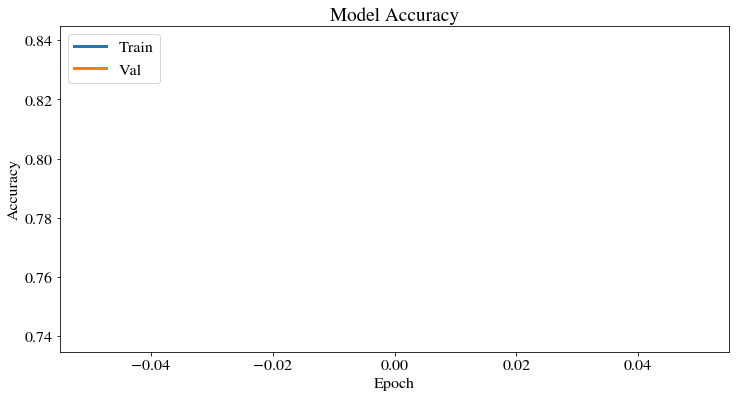

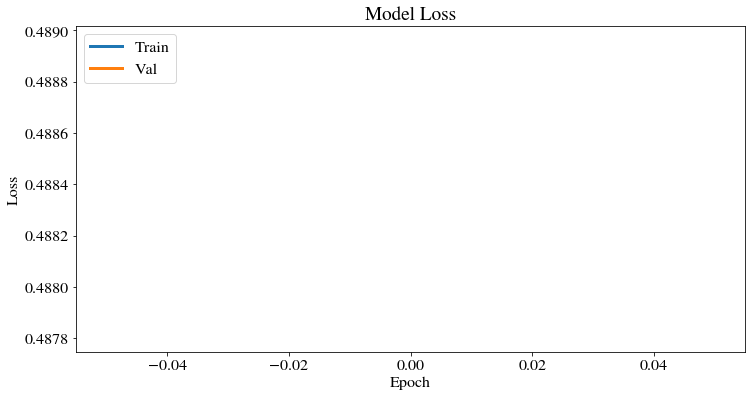

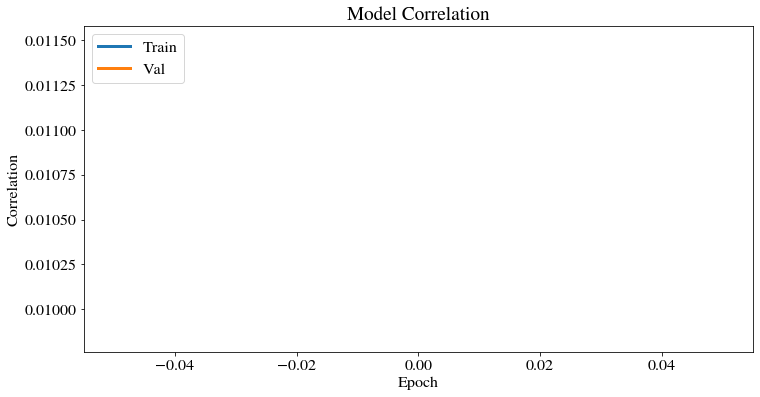

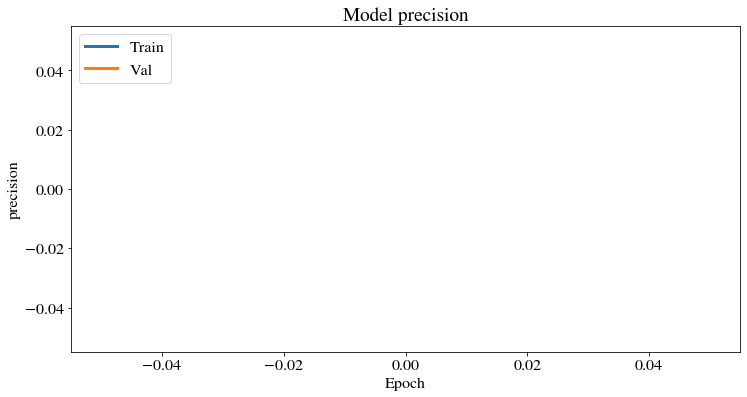

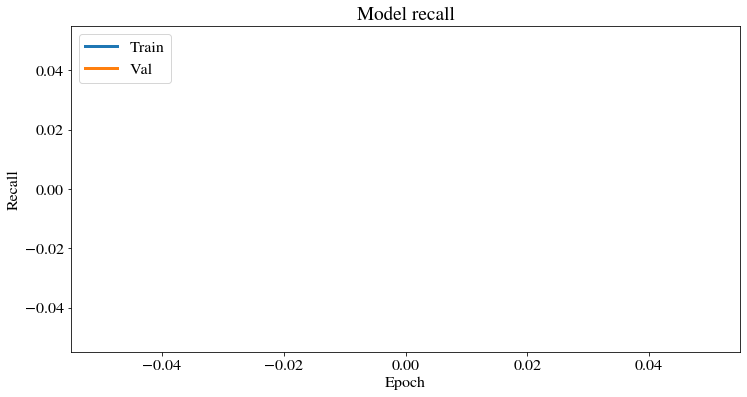

In [274]:
# Plot of loss, accuracy, cor, prec and recall
foldername = "/content/drive/My Drive/Results_project/test/"
plot_data.plot_history(history, normalization_min, save=False, foldername=foldername)

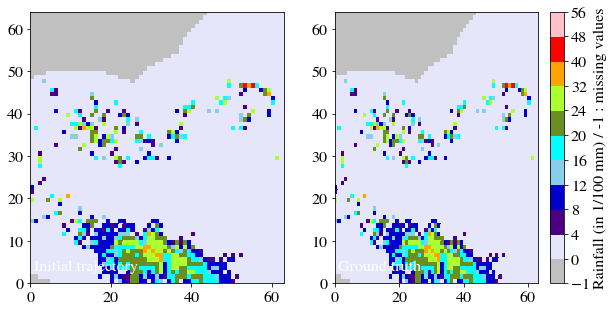

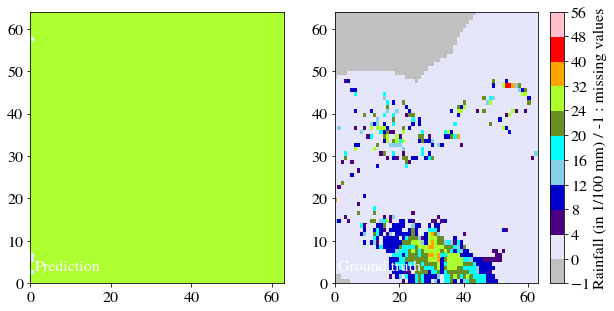

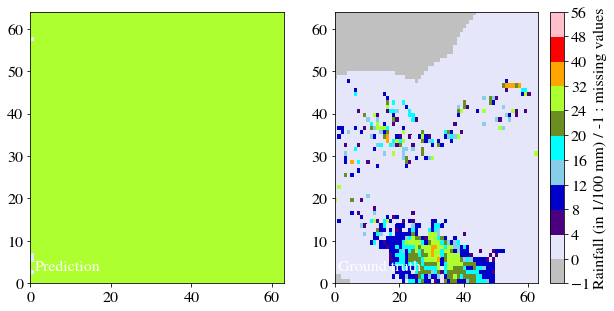

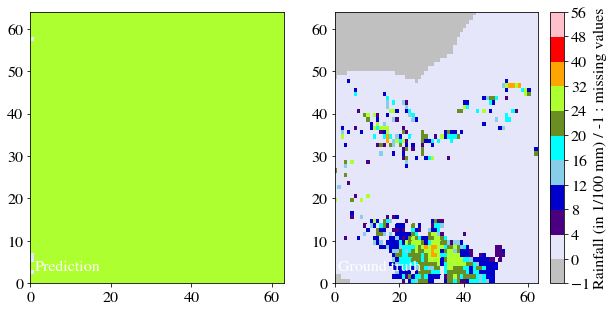

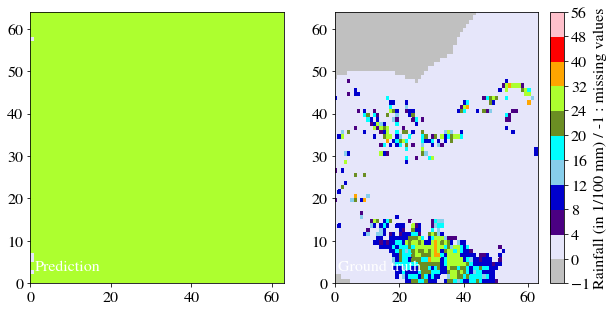

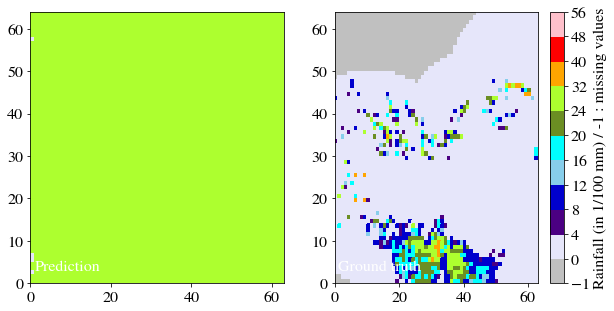

In [284]:
# Plot Train
if motion_content_data == 0:
  itest = 1
  track = X[itest, :, :, :, :]
  last_frame = X[itest, -1, :, :, :]
  track_y = y[itest, :, :, :, :]
  track = np.concatenate((last_frame[None, None,:,:,0:1], model.predict(track[None,:,:,:,:])), axis=1)
  true_track = np.concatenate((last_frame[None, :, :, 0:1], track_y), axis=0)
  plot_data.plot_track(true_track, track, rain_or_reflectivity, normalization_min, 
                       threshold_value, new_size, output_timeframes,
                       save=False, foldername='')
else:
  itest = 1
  track_content = X_content[itest]
  track_motion = X_motion[itest]
  track_y = y[itest, :, :, :, :]
  track = np.concatenate((track_content[None, None,:,:,0:1], model.predict([track_motion[None, :, :, :, :], track_content[None, :, :, :]])), axis=1)
  true_track = np.concatenate((track_content[None, :, :, 0:1], track_y), axis=0)
  plot_data.plot_track(true_track, track, rain_or_reflectivity, normalization_min, 
                       threshold_value, new_size, output_timeframes,
                       save=False, foldername='')
  

In [283]:
track_content[None, None,:,:,0:1].shape

TensorShape([1, 1, 64, 64, 1])

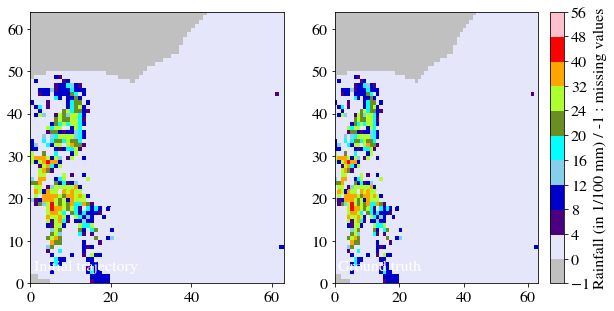

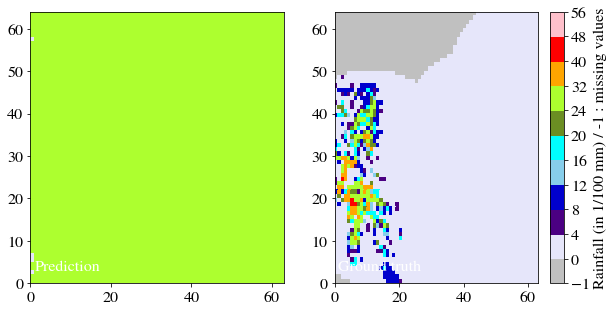

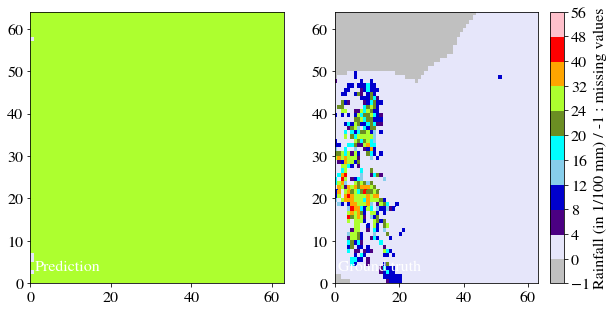

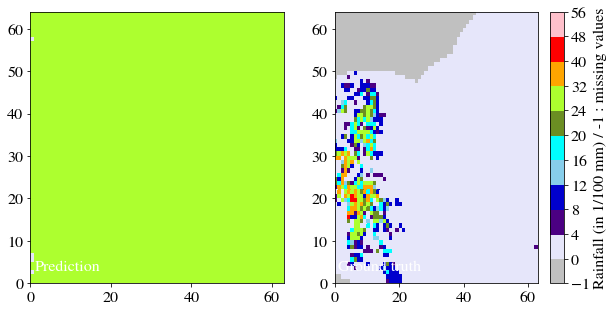

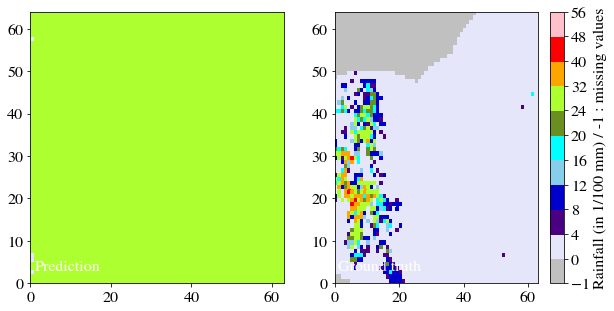

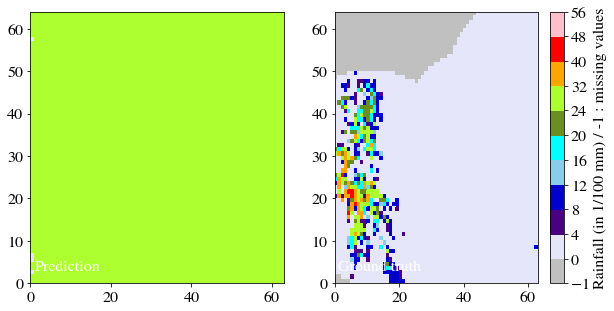

In [285]:
# Select a random observation, initial trajectory and predicted trajectory
# Plot Test
if motion_content_data == 0:
  itest = 1
  track = X_test[itest, :, :, :, :]
  last_frame = X_test[itest, -1, :, :, :]
  track_y = y_test[itest, :, :, :, :]
  track = np.concatenate((last_frame[None, None,:,:,0:1], model.predict(track[None,:,:,:,:])), axis=1)
  true_track = np.concatenate((last_frame[None, :, :, 0:1], track_y), axis=0)
  plot_data.plot_track(true_track, track, rain_or_reflectivity, normalization_min, 
                       threshold_value, new_size, output_timeframes,
                       save=False, foldername='')
else:
  itest = 1
  track_content = X_content_test[itest]
  track_motion = X_motion_test[itest]
  track_y = y_test[itest, :, :, :, :]
  track = np.concatenate((track_content[None, None,:,:,0:1], model.predict([track_motion[None, :, :, :, :], track_content[None, :, :, :]])), axis=1)
  true_track = np.concatenate((track_content[None, :, :, 0:1], track_y), axis=0)
  plot_data.plot_track(true_track, track, rain_or_reflectivity, normalization_min, 
                       threshold_value, new_size, output_timeframes,
                       save=False, foldername='')